The Multi-Armed Bandit (MAB) is a problem where an agent chooses among several options (arms), each with an unknown reward distribution, with the goal of maximizing cumulative reward over time. There are several ways to solve this problem, including Epsilon Greedy and Upper Confidence Bound (UCB). Let’s go through both:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Defining the distributions
class Arms:
    def __init__(self, type, param1, param2):
        self.type = type
        self.param1 = param1
        self.param2 = param2

    def get_reward(self):
        if self.type == 'uniform':
            return np.random.uniform(self.param1, self.param2)
        if self.type == 'gaussian':
            return np.random.normal(self.param1, self.param2)
        if self.type == 'exponential':
            return np.random.exponential(1.0 / self.param1)
        if self.type == 'beta':
            return np.random.beta(self.param1, self.param2)


In [2]:
# Ensure reproducible arm sampling
np.random.seed(42)

arm1 = Arms('uniform', 5, 10)
arm2 = Arms('gaussian', 6, 2)
arm3 = Arms('exponential', 1/4, 0)
arm4 = Arms('beta', 2, 5)
arm5 = Arms('uniform', -5, 0)
arm6 = Arms('gaussian', 10, 6)
arm7 = Arms('exponential', 1/7, 0)
arm8 = Arms('beta', 5, 2) 

arms = [arm1, arm2, arm3, arm4, arm5, arm6, arm7, arm8]

In epsilon greedy, we define a number epsilon which dictates how often we explore and exploit.  
Eploration consists of choosing a random arm and getting more information whilst exploiting is choosing the arm that you know gives the maximum rewards (based on the information you have so far).

In [3]:
class EpsilonGreedy:
    def __init__(self, arms, epsilon, steps):
        self.arms = arms
        self.epsilon = epsilon
        self.steps = steps
        # Estimated value of each arm and count of pulls
        self.value_estimates = np.zeros(len(arms))
        self.pull_counts = np.zeros(len(arms))
        self.cumulative_reward = 0.0
        self.reward_history = []
        np.random.seed(42)

    def select_action(self):
        # ε-greedy: explore with probability ε, otherwise exploit best estimate
        if np.random.rand() < self.epsilon:
            return np.random.randint(len(self.arms))
        best_val = np.max(self.value_estimates)
        candidates = np.where(self.value_estimates == best_val)[0]
        return np.random.choice(candidates)

    def update(self, action, reward):
        # record reward
        self.reward_history.append(reward)
        self.cumulative_reward += reward
        # incremental update of estimate
        self.pull_counts[action] += 1
        n = self.pull_counts[action]
        self.value_estimates[action] += (reward - self.value_estimates[action]) / n

    def run(self):
        for _ in range(self.steps):
            a = self.select_action()
            r = self.arms[a].get_reward()
            self.update(a, r)
            # decay exploration rate
            self.epsilon *= 0.995
        return self.cumulative_reward, self.value_estimates, self.reward_history


Total reward: 10362.58835504137
Estimated means: [ 7.66143565  5.15460622  1.27061446  0.28231903 -3.28573883 10.560771
  2.72978936  0.76048581]


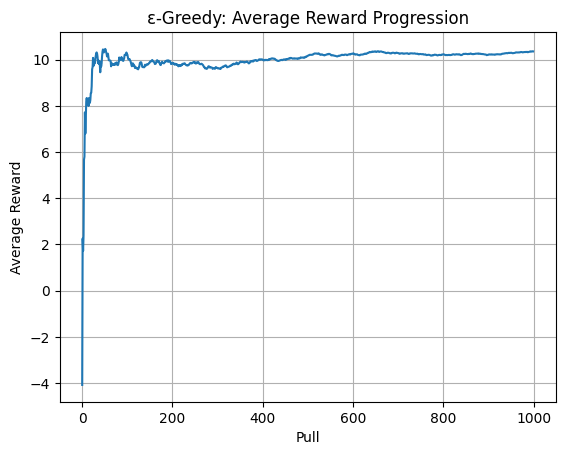

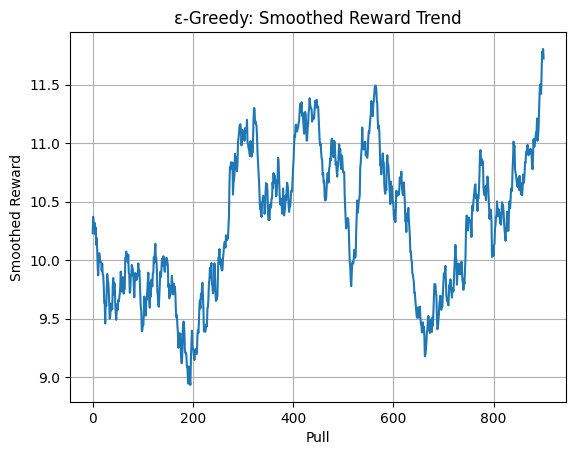

In [4]:
# Number of pulls and exploration rate
steps = 1000
epsilon = 0.15  # Play around with this value

# Run ε‑greedy bandit
banditEG = EpsilonGreedy(arms, epsilon, steps)
total_reward, estimated_rewards, rewards = banditEG.run()

print(f"Total reward: {total_reward}")
print(f"Estimated means: {estimated_rewards}")

# Plot average reward over time using cumulative sum
plt.plot(np.cumsum(rewards) / np.arange(1, len(rewards) + 1))
plt.xlabel("Pull")
plt.ylabel("Average Reward")
plt.title("ε‑Greedy: Average Reward Progression")
plt.grid(True)
plt.show()

# Plot smoothed reward curve (moving average window = 100)
plt.plot(np.convolve(rewards, np.ones((100,)) * 0.01, mode="valid"))
plt.xlabel("Pull")
plt.ylabel("Smoothed Reward")
plt.title("ε‑Greedy: Smoothed Reward Trend")
plt.grid(True)
plt.show()


In upper confidence bound, we have the upper confidence estimate where we use both the estimated mean and the number of times we have picked that option. The more times you have chosen something, the more certain you are of its estimated mean. Using this we have 2 terms, the estimated mean and the confidence score. The constant c dictates how much the confidence score affects our choice.

$UCB_t(a) = \hat{Q}_t(a) + c \cdot \sqrt{\frac{\ln t}{N_t(a)}}$  
$\hat{Q}_t(a)$ is the estimated reward. $N_t(a)$ is the number of times arm $a$ has been picked and $t$ is the timestamp

In [5]:
class UpperConfidenceBound:
    def __init__(self, arms, steps, c):
        self.arms = arms
        self.steps = steps
        self.c = c
        # TODO: Initialize parameters
        self.estimated_rewards = np.zeros(len(self.arms))  # Estimated rewards of all arms
        self.action_count     = np.zeros(len(self.arms))  # Count of pulls per arm
        self.total_reward     = 0
        self.rewards          = []

    def select_action(self, t):
        # TODO: First, play each arm at least once.
        for idx in range(len(self.arms)):
            if self.action_count[idx] == 0:
                return idx

        # Compute UCB scores and pick the highest
        confidence = self.c * np.sqrt(np.log(t) / self.action_count)
        ucb_scores = self.estimated_rewards + confidence
        return int(np.argmax(ucb_scores))

    def update(self, action, reward):
        # TODO: Update estimated_rewards, action_count, total_reward, and rewards array here
        self.rewards.append(reward)
        self.total_reward += reward
        self.action_count[action] += 1

        n = self.action_count[action]
        value = self.estimated_rewards[action]
        # incremental mean update
        self.estimated_rewards[action] = value + (reward - value) / n

    def run(self):
        for t in range(1, self.steps + 1):
            action = self.select_action(t)
            reward = self.arms[action].get_reward()
            self.update(action, reward)
        return self.total_reward, self.estimated_rewards, self.rewards


Total reward: 9838.983305988484
Estimated means: [ 7.61036661  3.35995498  0.18689394  0.26055355 -2.58979471  9.9080586
  2.306174    0.63542578]


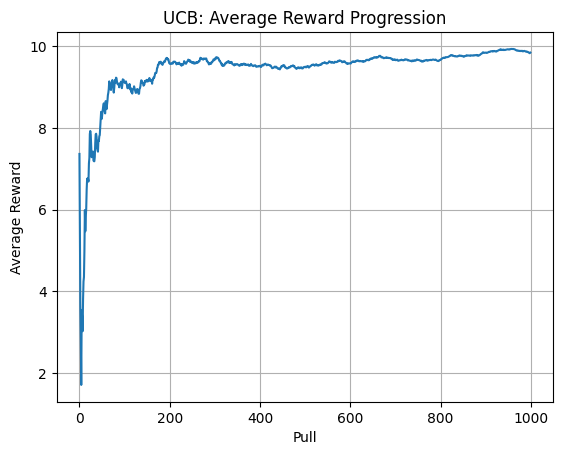

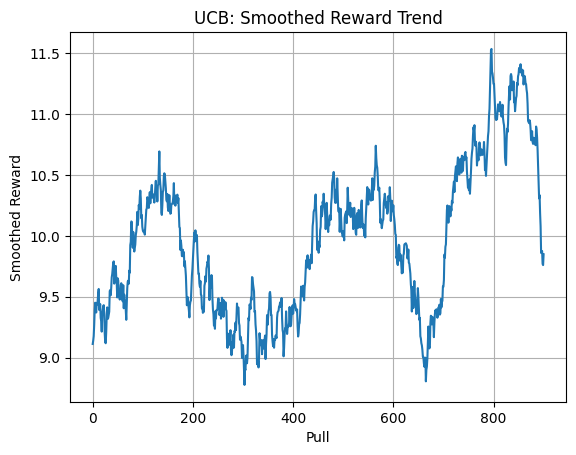

In [6]:
steps = 1000
c = 1.4  # Play around with this value

banditUCB = UpperConfidenceBound(arms, steps, c)
total_reward, estimated_means, reward_history = banditUCB.run()

print(f"Total reward: {total_reward}")
print(f"Estimated means: {estimated_means}")

# TODO: Plot average rewards over time (use np.cumsum)
avg_rewards = np.cumsum(reward_history) / np.arange(1, len(reward_history) + 1)
plt.plot(avg_rewards)
plt.xlabel("Pull")
plt.ylabel("Average Reward")
plt.title("UCB: Average Reward Progression")
plt.grid(True)
plt.show()

# Plot a smoothed reward curve (window = 100)
window = 100
smoothed = np.convolve(reward_history, np.ones(window) / window, mode="valid")
plt.plot(smoothed)
plt.xlabel("Pull")
plt.ylabel("Smoothed Reward")
plt.title("UCB: Smoothed Reward Trend")
plt.grid(True)
plt.show()


## Optional challenges

1. if you already know the distribution the arms draw from(eg: gaussian), can you incorporate that knowledge to learn faster

We will host a competition where we will run your agents and host a leaderboard(details in the next meet)